# **SMU Course Bidding Prediction Using CatBoost V1**

<h2><span style="color:red">NOTE: use at your own descretion.</span>

### **Difference between V1 and V2**
- V1: Using readily available BOSS data found on OASIS.
- V2: Using scraped data from BOSS Bidding website on class and exam timings, locations, and grading basis.

### **Objective**
This notebook predicts the minimum bid required for courses in the SMU bidding system using a **CatBoost** regression model. Four distinct models are developed and evaluated:

1. Default Model: A baseline model with default parameters.
2. Tuned Model: A model with optimized hyperparameters using grid search.
3. Tuned + Cleaned Model: A model trained on data after removing outliers.
4. Tuned + Historical Average Features: A model with additional features such as historical average minimum bid prices.

Thereafter choosing the best model, we will:
1. Safety factor vs TPR.
2. Feature importance.
3. Confidence Interval for prediction.
4. Conclusion.

The columns in the CSV are:
`Term, Description, Section, Vacancy, Min Bid, Instructor, AY, Round, Window, SubjectArea, CatalogueNo, BidderCount`

Note: The logic for determining the test dataset is that we take all rows with `AY=2024` and `Term=1` or `Term=2` as the test set, and the rest as training.


Make sure to have `catboost` installed via `pip install catboost`.

---

## **1. Data Preparation**

### 1.1 **Loading the Data**
- Import necessary libraries.
- Load the dataset and display its structure.

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_log_error

# Load data
data = pd.read_csv('transformed_data.csv')  # Ensure this file is in your working directory
print("Data Shape:", data.shape)
display(data.head())

Data Shape: (36718, 12)


,Term,Description,Section,Vacancy,Min Bid,Instructor,AY,Round,Window,SubjectArea,CatalogueNo,BidderCount
0,2,Financial Reporting and Analysis,G3,42,25.00,GOH BENG WEE,2021,6.0,3,ACCT,224,1
1,2,Valuation,G1,42,10.09,CHENG NAM SANG,2021,6.0,3,ACCT,336,1
2,2,Valuation,G2,42,10.00,CHENG NAM SANG,2021,6.0,3,ACCT,336,2
3,2,Auditing for the Public Sector,G1,42,25.00,LIM SOO PING,2021,6.0,3,ACCT,409,1
4,2,Public Relations Writing,G1,45,10.00,YASMIN HANNAH RAMLE,2021,6.0,3,COMM,225,1



---

### 1.2 **Standardizing Data Types**
- Ensure proper data types for numeric and categorical columns.

In [62]:
# Ensure proper data types for all columns
def standardise_data_types(data):
    # Convert numeric columns
    data['AY'] = pd.to_numeric(data['AY'], errors='coerce')
    data['Term'] = pd.to_numeric(data['Term'], errors='coerce')
    data['Vacancy'] = pd.to_numeric(data['Vacancy'], errors='coerce')
    data['Min Bid'] = pd.to_numeric(data['Min Bid'], errors='coerce')
    data['BidderCount'] = pd.to_numeric(data['BidderCount'], errors='coerce')

    # Convert Round: fill NaN with 0 and make it integer
    data['Round'] = data['Round'].fillna(0).astype(int)

    # Convert CatalogueNo to object
    data['CatalogueNo'] = data['CatalogueNo'].astype('object')

    # Ensure object columns are properly typed
    object_cols = ['Description', 'Section', 'Instructor', 'SubjectArea']
    for col in object_cols:
        data[col] = data[col].astype('object')

    return data

# Apply standardisation
data = standardise_data_types(data)


---

### 1.3 **Train-Test Split**
Define the test set as AY=2024 and Term=1 or Term=2

In [63]:
# Define test set as AY=2024 and Term=1 or Term=2
test_mask = (data['AY'] == 2024) & (data['Term'].isin([1, 2]))
test_data = data[test_mask].copy()
train_data = data[~test_mask].copy()

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)

Train shape: (28067, 12)
Test shape: (8651, 12)



---

## **2. Model Development**

### **2.1 Default Model Selection**
The baseline model is created using default CatBoost parameters.

In [64]:
target = 'Min Bid'
features = ['Term', 'Description', 'Section', 'Vacancy', 'Instructor', 'AY', 'Round', 'Window', 'SubjectArea', 'CatalogueNo', 'BidderCount']
cat_features = ['Description', 'Section', 'Instructor', 'SubjectArea', 'CatalogueNo']

X_train = train_data[features]
y_train = train_data[target]

X_test = test_data[features]
y_test = test_data[target]

In [65]:
# Train the default model
default_model  = CatBoostRegressor(cat_features=cat_features, verbose=False)
default_model.fit(X_train, y_train)

In [66]:
# Evaluate the default model
y_pred_default = default_model.predict(X_test)

# Set minimum prediction value to 10
min_threshold = 10
y_pred_default = np.maximum(y_pred_default, min_threshold)

msle_default = mean_squared_log_error(y_test, y_pred_default)

print("Default Model MSLE:", msle_default)

Default Model MSLE: 0.2648173297003864


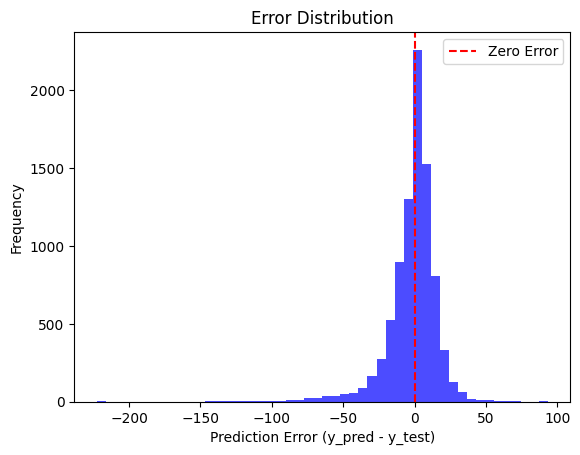

Mean Error: -1.490701588882897
Median Error: 0.8001048294726285
Fraction of Predictions Below Actual: 44.71%


In [67]:
errors_default = y_pred_default - y_test

plt.hist(errors_default, bins=50, alpha=0.7, color='blue')
plt.axvline(0, color='red', linestyle='--', label='Zero Error')
plt.xlabel('Prediction Error (y_pred - y_test)')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.legend()
plt.show()

mean_error_default = np.mean(errors_default)
median_error_default = np.median(errors_default)
below_zero_default = np.mean(errors_default < 0)  # Fraction of under-predictions
print(f"Mean Error: {mean_error_default}")
print(f"Median Error: {median_error_default}")
print(f"Fraction of Predictions Below Actual: {below_zero_default:.2%}")


---

### **2.2 Tuned Model**
Perform hyperparameter tuning and train a tuned model.

In [42]:
# Hyperparameter Tuning with Plot
param_grid = {
    'iterations': [200, 500, 1000],
    'learning_rate': [0.1, 0.05, 0.01],
    'depth': [6, 8, 10],
    'l2_leaf_reg': [1, 3, 5],
    'bagging_temperature': [0.5, 1, 2],
    'random_strength': [1, 2],
}

model = CatBoostRegressor(task_type="GPU", devices='0', eval_metric="RMSE", logging_level="Silent",cat_features=cat_features) #NOTE: RMSE used instead of MSLE because CatBoost doesn't support MSLE

# Uncomment if you need grid_search yourself. Appoximate time taken is 3.5 hours.
# grid_search_result = model.grid_search(
#     param_grid,
#     X=X_train,
#     y=y_train,
#     cv=5,                       # 5-fold cross-validation
#     partition_random_seed=42,   # Seed for reproducibility
#     shuffle=True,               # Shuffle data before splitting
#     stratified=False,           # Not stratified since it's regression
#     verbose=True,               # Show updates during search
#     plot=True                   # Enable plot for visualisation
# )

print("Best Parameters:", grid_search_result['params'])
print("Cross-Validation Results:")
print(grid_search_result['cv_results'])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 16.2934055	best: 16.2934055 (0)	total: 7.41s	remaining: 59m 55s
1:	loss: 16.4538311	best: 16.2934055 (0)	total: 14.5s	remaining: 58m 26s


KeyboardInterrupt: 

Best Parameters: {'bagging_temperature': 1, 'random_strength': 1, 'depth': 10, 'learning_rate': 0.1, 'l2_leaf_reg': 5, 'iterations': 1000}

In [51]:
tuned_model = CatBoostRegressor(
    bagging_temperature= 1,
    random_strength=1,
    depth=10,
    learning_rate=0.1,
    l2_leaf_reg=5,
    iterations=1000,
    cat_features=cat_features,
    verbose=False
)

tuned_model.fit(X_train, y_train)

In [68]:
# Evaluate the tuned model
y_pred_tuned = tuned_model.predict(X_test)

# Set minimum prediction value to 10
min_threshold = 10
y_pred_tuned = np.maximum(y_pred_tuned, min_threshold)

msle_tuned = mean_squared_log_error(y_test, y_pred_tuned)

print("Tuned Model MSLE:", msle_tuned)

Tuned Model MSLE: 0.2637815173331763


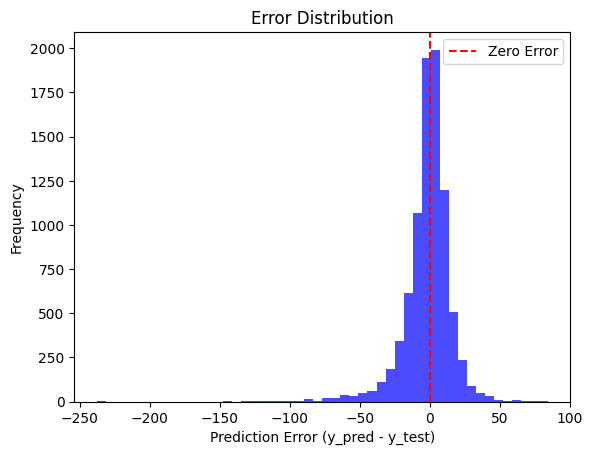

Mean Error: -1.6248895698459331
Median Error: 0.2614534584848833
Fraction of Predictions Below Actual: 46.35%


In [70]:
errors_tuned = y_pred_tuned - y_test

plt.hist(errors_tuned, bins=50, alpha=0.7, color='blue')
plt.axvline(0, color='red', linestyle='--', label='Zero Error')
plt.xlabel('Prediction Error (y_pred - y_test)')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.legend()
plt.show()

mean_error_tuned = np.mean(errors_tuned)
median_error_tuned = np.median(errors_tuned)
below_zero_tuned = np.mean(errors_tuned < 0)  # Fraction of under-predictions
print(f"Mean Error: {mean_error_tuned}")
print(f"Median Error: {median_error_tuned}")
print(f"Fraction of Predictions Below Actual: {below_zero_tuned:.2%}")


---

### **2.3 Tuned + Cleaned Model**
Remove outliers and train the tuned model on cleaned data.

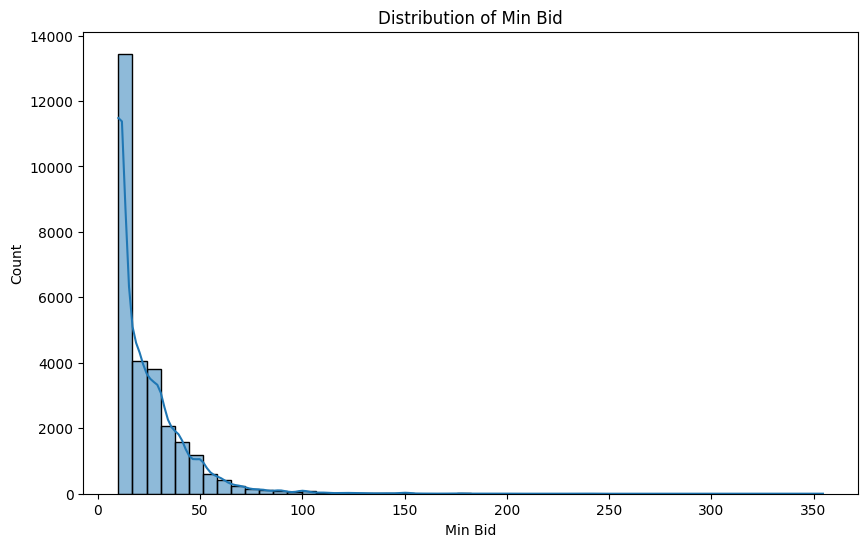

In [71]:
# Plot Min Bid Distribution to Understand Outliers
plt.figure(figsize=(10, 6))
sns.histplot(train_data['Min Bid'], bins=50, kde=True)
plt.title('Distribution of Min Bid')
plt.show()

In [88]:
# Compute IQR for Outlier Removal
q1 = train_data['Min Bid'].quantile(0.25)
q3 = train_data['Min Bid'].quantile(0.75)
iqr = q3 - q1

# Define Lower and Upper Boundaries
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

print(f"IQR Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")

# Filter Outliers
cleaned_train_data = train_data[(train_data['Min Bid'] >= lower_bound) & (train_data['Min Bid'] <= upper_bound)]

print("Original Training Data Shape:", train_data.shape)
print("Cleaned Training Data Shape:", cleaned_train_data.shape)

IQR Lower Bound: -19.464999999999996, Upper Bound: 59.695
Original Training Data Shape: (28067, 13)
Cleaned Training Data Shape: (26808, 13)


In [89]:
# Define new training set
X_train_cleaned = cleaned_train_data[features]
y_train_cleaned = cleaned_train_data[target]

In [90]:
# Train CatBoost Regressor with Cleaned Data
model_cleaned = CatBoostRegressor(
    bagging_temperature=1,
    random_strength=1,
    depth=10,
    learning_rate=0.1,
    l2_leaf_reg=5,
    iterations=1000,
    cat_features=cat_features,
    verbose=False
)

model_cleaned.fit(X_train_cleaned, y_train_cleaned)

In [91]:
# Predictions with Cleaned Model
y_pred_cleaned = model_cleaned.predict(X_test)

# Set minimum prediction value to 10
min_threshold = 10
y_pred_cleaned = np.maximum(y_pred_cleaned, min_threshold)

# Compute Metrics for Cleaned Model
msle_cleaned = mean_squared_log_error(y_test, y_pred_cleaned)

print("Cleaned Model MSLE:", msle_cleaned)

Cleaned Model MSLE: 0.2586778136376485


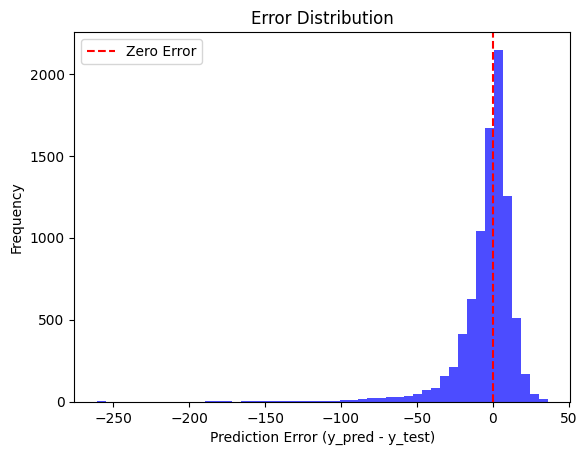

Mean Error: -3.6913726611647157
Median Error: 0.132685411387639
Fraction of Predictions Below Actual: 48.13%


In [92]:
errors_cleaned = y_pred_cleaned - y_test

plt.hist(errors_cleaned, bins=50, alpha=0.7, color='blue')
plt.axvline(0, color='red', linestyle='--', label='Zero Error')
plt.xlabel('Prediction Error (y_pred - y_test)')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.legend()
plt.show()

mean_error_cleaned = np.mean(errors_cleaned)
median_error_cleaned = np.median(errors_cleaned)
below_zero_cleaned = np.mean(errors_cleaned < 0)  # Fraction of under-predictions
print(f"Mean Error: {mean_error_cleaned}")
print(f"Median Error: {median_error_cleaned}")
print(f"Fraction of Predictions Below Actual: {below_zero_cleaned:.2%}")


---

### **2.4 Tuned + Historical Average Features**
Add historical average bid prices as a new feature.

In [77]:
# Function to calculate historical mean minimum bid excluding current row
def add_historical_mean_min_bid(data, group_cols, target_col):
    data['Historical Mean Min Bid'] = (
        data.groupby(group_cols)[target_col]
        .transform(lambda x: x.expanding().mean().shift(1))
    )
    return data

# Apply the function to compute the column
train_data = add_historical_mean_min_bid(train_data, group_cols=['Description', 'Instructor'], target_col='Min Bid')
test_data['Historical Mean Min Bid'] = test_data['Description'].map(
    train_data.groupby(['Description', 'Instructor'])['Min Bid'].mean()
)

# Display a sample of the updated data
display(train_data[['Description', 'Instructor', 'Min Bid', 'Historical Mean Min Bid']].head(10))

,Description,Instructor,Min Bid,Historical Mean Min Bid
0,Financial Reporting and Analysis,GOH BENG WEE,25.00,NaN
1,Valuation,CHENG NAM SANG,10.09,NaN
2,Valuation,CHENG NAM SANG,10.00,10.09
3,Auditing for the Public Sector,LIM SOO PING,25.00,NaN
4,Public Relations Writing,YASMIN HANNAH RAMLE,10.00,NaN
5,Designing Communication for Behavioural Change,SUNGJONG ROH,10.00,NaN
6,Management Communication,CHAN BOH YEE,35.00,NaN
7,Japanese,"AKIKO ITO, AKIKO ITO",26.44,NaN
8,"Business, Government and Society",CHAN KAY MIN,25.00,NaN
9,Spreadsheet Modeling and Analytics,KARTHIKEYAN KANNAN,40.00,NaN


In [78]:
# # Ensure features is a list
# features = list(features)

# Add the new feature to the list
features.append('Historical Mean Min Bid')

# Retrain the model with the new feature
X_train = train_data[features]
X_test = test_data[features]

model_with_history = CatBoostRegressor(
    bagging_temperature=1,
    random_strength=1,
    depth=10,
    learning_rate=0.1,
    l2_leaf_reg=5,
    iterations=1000,
    cat_features=cat_features,
    verbose=False
)

model_with_history.fit(X_train, y_train)

In [79]:
# Evaluate the tuned + historical average model
y_pred_history = model_with_history.predict(test_data[features])

# Set minimum prediction value to 10
min_threshold = 10
y_pred_history = np.maximum(y_pred_history, min_threshold)

msle_history = mean_squared_log_error(y_test, y_pred_history)
print("Tuned + Historical Model MSLE:", msle_history)

Tuned + Historical Model MSLE: 0.28131750680363


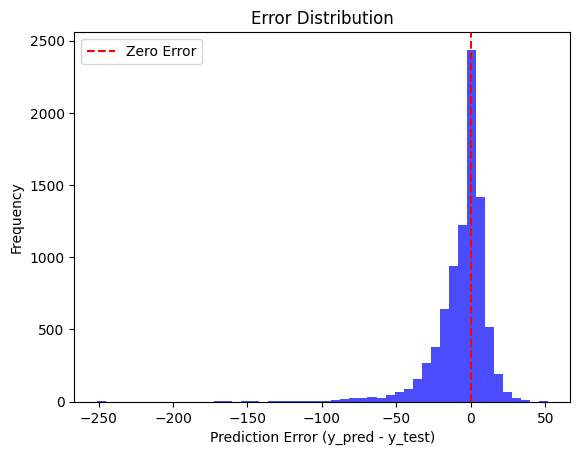

Mean Error: -6.211099659402047
Median Error: -1.4686306458444154
Fraction of Predictions Below Actual: 56.47%


In [80]:
errors_history = y_pred_history - y_test

plt.hist(errors_history, bins=50, alpha=0.7, color='blue')
plt.axvline(0, color='red', linestyle='--', label='Zero Error')
plt.xlabel('Prediction Error (y_pred - y_test)')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.legend()
plt.show()

mean_error_history = np.mean(errors_history)
median_error_history = np.median(errors_history)
below_zero_history = np.mean(errors_history < 0)  # Fraction of under-predictions
print(f"Mean Error: {mean_error_history}")
print(f"Median Error: {median_error_history}")
print(f"Fraction of Predictions Below Actual: {below_zero_history:.2%}")


---

## **3. Model Comparison and selection**
Select the model with the lowest MSLE.

In [81]:
print("Model Comparison:")
print(f"Default Model MSLE: {msle_default}")
print(f"Tuned Model MSLE: {msle_tuned}")
print(f"Tuned + Cleaned Model MSLE: {msle_cleaned}")
print(f"Tuned + Historical Model MSLE: {msle_history}")

Model Comparison:
Default Model MSLE: 0.2648173297003864
Tuned Model MSLE: 0.2637815173331763
Tuned + Cleaned Model MSLE: 0.2586778136376485
Tuned + Historical Model MSLE: 0.28131750680363



---

## **4. Safety Factor Analysis**
Find safety factors for the best model.

MSLE: 0.2586778136376485
Initial TPR (no safety factor): 0.5186683620390706


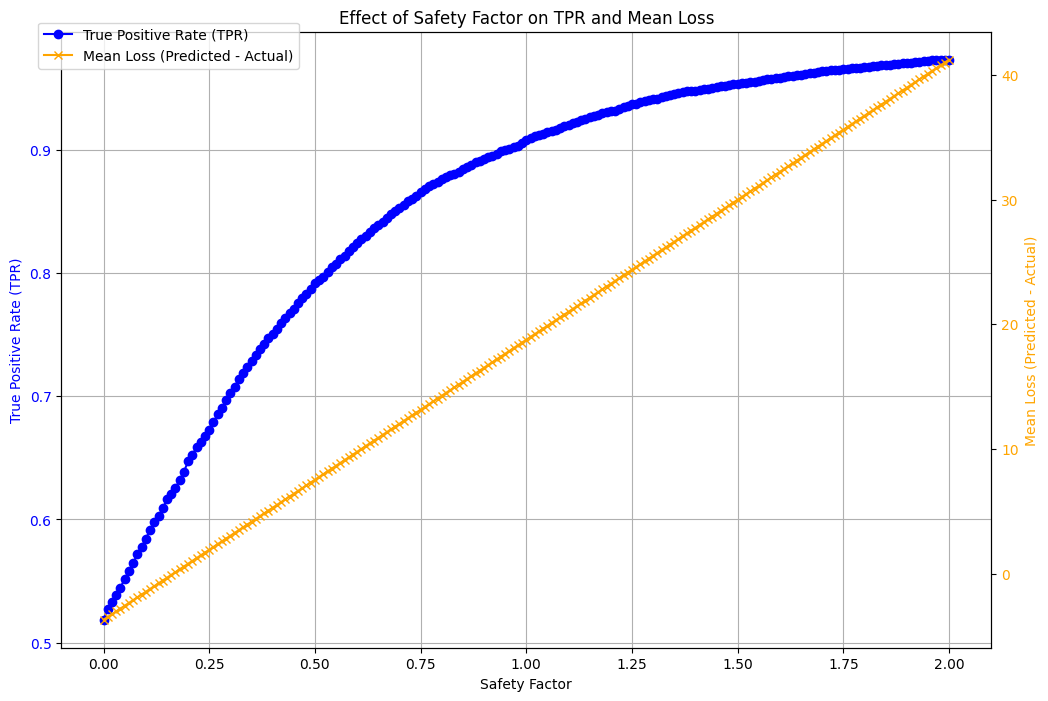

In [82]:
# Initialize lists to store results
safety_factors = np.arange(0.00, 2.01, 0.01)
tpr_values = []
loss_values = []

# Loop through safety factors
for sf in safety_factors:
    # Apply safety factor to predictions
    adjusted_pred = y_pred_cleaned * (1 + sf)

    # Compute TP Rate
    pred_binary = (adjusted_pred >= y_test).astype(int)
    tp_rate = pred_binary.mean()

    # Compute Mean Loss (average difference between predicted and actual)
    mean_loss = np.mean(adjusted_pred - y_test)

    # Store TPR and Loss
    tpr_values.append(tp_rate)
    loss_values.append(mean_loss)

# Print MSLE and initial TPR (without safety factor)
print("MSLE:", msle_cleaned)
print("Initial TPR (no safety factor):", tpr_values[0])

# Plot TPR and Mean Loss with Dual Y-Axes
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot TPR on the left y-axis
ax1.plot(safety_factors, tpr_values, marker='o', color='blue', label='True Positive Rate (TPR)')
ax1.set_xlabel('Safety Factor')
ax1.set_ylabel('True Positive Rate (TPR)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Effect of Safety Factor on TPR and Mean Loss')
ax1.grid(True)

# Plot Mean Loss on the right y-axis
ax2 = ax1.twinx()
ax2.plot(safety_factors, loss_values, marker='x', color='orange', label='Mean Loss (Predicted - Actual)')
ax2.set_ylabel('Mean Loss (Predicted - Actual)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add a legend for clarity
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()


---

## **5. Feature Importance**
Identify top features for the best model.

        Feature  Importance
4    Instructor   14.768449
1   Description   13.719753
6         Round   12.423896
8   SubjectArea   11.460110
2       Section   10.623875
10  BidderCount   10.302946
9   CatalogueNo   10.249389
7        Window    5.803201
5            AY    4.988798
0          Term    3.945865


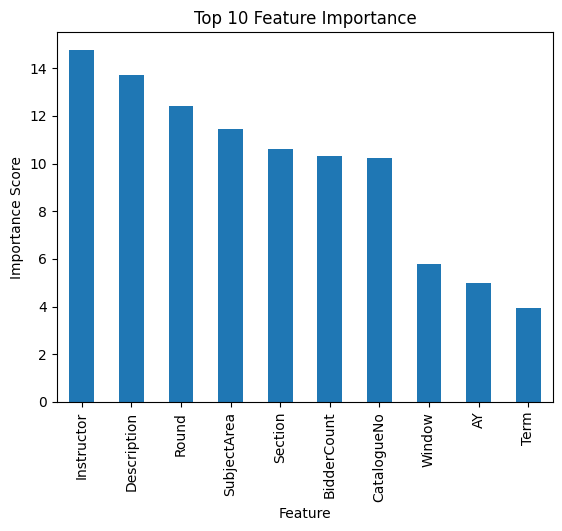

In [84]:
# Use model's internal feature names
features = model_cleaned.feature_names_

# Get feature importance scores
feature_importance = model_cleaned.get_feature_importance(type='FeatureImportance')

# Create a DataFrame for better readability
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display top 3 features
top_features = importance_df.head(10)
print(top_features)

# Visualize feature importance
top_features.plot(kind='bar', x='Feature', y='Importance', legend=False, title="Top 10 Feature Importance")
plt.ylabel("Importance Score")
plt.show()


---

## **6. Confidence Interval for a Prediction**
Estimate a 95% confidence interval using boostrapping

1. Take a single new data point.
2. Perform bootstrap by training multiple models on resampled data.
3. Predict on the single instance each time.
4. Compute mean and std of these predictions.
5. Derive a 95% CI (mean ± 1.96*std).

In [85]:
# Example single instance
# Adjust these values as needed:
new_data = pd.DataFrame({
    'Term': [1],
    'Description': ["Financial Analytics"],
    'Section': ["G1"],
    'Vacancy': [45],
    'Instructor': ["RANDALL EUGENE DURAN"],
    'AY': [2024],
    'Round': [1],
    'Window': [1],
    'SubjectArea': ["IS"],
    'CatalogueNo': ["453"],
    'BidderCount': [35]
})

# Predict with the main model
single_pred = model_cleaned.predict(new_data)
print("Predicted Min Bid:", single_pred[0])

Predicted Min Bid: 38.093810282964895


### Bootstrap-based Confidence Interval
We'll retrain the model multiple times on bootstrap samples of the training data and predict each time.

In [86]:
n_bootstrap = 10
bootstrap_preds = []

for i in range(n_bootstrap):
    # Sample training data with replacement
    sample = cleaned_train_data.sample(frac=1.0, replace=True)
    X_sample = sample[features]
    y_sample = sample[target]
    
    temp_model = CatBoostRegressor(
        iterations=200,
        learning_rate=0.1,
        depth=6,
        cat_features=cat_features,
        verbose=False
    )
    temp_model.fit(X_sample, y_sample)
    
    # Predict on the single new instance
    single_boot_pred = temp_model.predict(new_data)
    bootstrap_preds.append(single_boot_pred[0])

bootstrap_preds = np.array(bootstrap_preds)
mean_pred = bootstrap_preds.mean()
std_pred = bootstrap_preds.std()

# Approximate 95% CI assuming normal distribution
ci_lower = mean_pred - 1.96 * std_pred
ci_upper = mean_pred + 1.96 * std_pred

print(f"Single Instance Prediction: {mean_pred:.2f}")
print(f"Approx. 95% Confidence Interval: [{ci_lower:.2f}, {ci_upper:.2f}]")

Single Instance Prediction: 27.88
Approx. 95% Confidence Interval: [24.81, 30.96]



---

## **7. Conclusion**

### **What Was Done**
In this notebook, we explored and developed a predictive model to forecast the minimum bid required for courses in the SMU bidding system. The steps included:
1. **Baseline Model Development**:
   - A CatBoost regression model was built using default parameters to establish a performance benchmark.
2. **Hyperparameter Tuning**:
   - Leveraged grid search to optimize model parameters, improving accuracy.
3. **Outlier Handling**:
   - Removed extreme outliers from the training data, which resulted in slightly better performance.
4. **Feature Engineering**:
   - Incorporated historical average minimum bid prices to enhance the model’s predictive capabilities.
5. **Evaluation of Trade-offs**:
   - Evaluated various models using MSLE and other metrics to understand the trade-offs between accuracy and generalizability.
6. **Importance Analysis**:
   - Identified the most significant features driving the predictions, such as instructor, description, and bidding round.

---

### **What Can Be Concluded**
1. **Best Model**: 
   - The cleaned model with outliers removed performed the best, albeit by a small margin. While the improvements were incremental, handling outliers allowed the model to squeeze out the last bit of accuracy, supporting the notion that outliers minimally affect tree-based models but are not entirely inconsequential.

2. **Insights into Features**:
   - The instructor, description, and bidding round were the top predictors of the minimum bid. For example, certain instructors or high-demand courses had higher minimum bids, as expected.

3. **Performance of Other Enhancements**:
   - Including historical averages of minimum bids added minimal value to the model's accuracy.
   - Hyperparameter tuning provided moderate improvements over the baseline but was less impactful than cleaning the data.

---

### **What to Do Next**
1. **Advanced Feature Engineering**:
   - Explore deeper embedding techniques for categorical variables (e.g., using neural networks).
   - Include additional external features such as overall course popularity or prior term enrollment data.
   - Removing outliers that may be obvious (troll bids from graduating students with alot of credits).
2. **Alternative Models**:
   - Experiment with other machine learning approaches, such as ensemble models (e.g., XGBoost) or deep learning models, to handle categorical embeddings better.
3. **Collect more data**:
   - Scrape BOSS Bidding website for additional information such as class and exam timings, locations, and grading basis.
   - Crowd source individual bids from SMU students to increase data. However, whatever information gained from this would likely prove inconsequential when the ML models is used to aid students in making prediction.

By systematically handling data, optimizing models, and interpreting results, this notebook provides a robust framework for predicting minimum course bid prices in a dynamic and competitive environment.